In [8]:
%matplotlib notebook
import keras as keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,BatchNormalization,Dropout,Flatten, Conv1D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras import regularizers,optimizers
from keras.regularizers import l2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import gzip
from keras.layers.core import Lambda
from scipy.integrate import trapz
import seaborn as sns

from keras.layers.core import Lambda
from keras import backend as K    


def mini_batches(InputSample,BatchSize):
    Index = np.array(range(InputSample.shape[0]),dtype=int)
    NumBatches = np.int(InputSample.shape[0]/BatchSize)
    Removed = np.array([],dtype=int)

    BatchInd =[]
    for BatchLoop in range(NumBatches):
        RemainIndex = np.delete(Index,Removed)
        SampleInd = np.random.choice(RemainIndex,size=BatchSize,replace=False)
        Removed = np.append(Removed,SampleInd,axis=0)

        BatchInd.append(SampleInd)
    RemainIndex = np.delete(Index,Removed)
    BatchInd.append(RemainIndex)

    return BatchInd,NumBatches
    
def Get_Feats_and_Targets(filename):
    import numpy as np
    
    def line_to_Feats(line):
        line = line.split(' ')
        Feats = np.asarray(line[0:1024])
        Target = np.zeros([3])
        Target[int(line[1024])] = 1
        return Feats,Target

    f = open(filename, 'r')
    lines = f.readlines()
    Features = []
    Targets = []
    for i in range(len(lines)-1):
        line = lines[i+1]
        Feats,Tgts = line_to_Feats(line)
        Features.append(Feats)
        Targets.append(Tgts)
        
    return np.asarray(Features,dtype = 'float64'), np.asarray(Targets,dtype = 'int')

In [9]:
FullInputs = scipy.io.loadmat('MNIST_TrainInputs.mat')
FullInputs = FullInputs['images']

FullTargets = scipy.io.loadmat('MNIST_TrainTargets.mat')
FullTargets = FullTargets['targets']


In [10]:
Validation_Cutoff = 0.5

Validation_Cutoff = np.int(Validation_Cutoff*FullInputs.shape[0])

ValInputs = FullInputs[Validation_Cutoff:,:]
ValTargets = FullTargets[Validation_Cutoff:,:]

TrainInputs = FullInputs[0:Validation_Cutoff,:]
TrainTargets = FullTargets[0:Validation_Cutoff,:]

In [11]:
data_dim = TrainInputs.shape[-1]
NumSamples = TrainInputs.shape[0]
Num_Targets = TrainTargets.shape[-1]

index = np.linspace(0,NumSamples,NumSamples,endpoint=False,dtype=int)

reg_coeff = 0.001

def Gen_Model(reg_coeff):
    model = Sequential()
    model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dropout(0.25))
    model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dropout(0.25))
    model.add(Dense(100,activation='relu',input_shape =(data_dim,),kernel_regularizer=l2(reg_coeff)))
    model.add(Dropout(0.25))
    model.add(Dense(Num_Targets,activation = 'softmax',kernel_regularizer=l2(reg_coeff),input_shape =(data_dim,)))
    optim = optimizers.adam(lr=0.00001)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['categorical_accuracy'])
    return model
    
D2THard_model = Gen_Model(reg_coeff)
D2TEasy_model = Gen_Model(reg_coeff)

EntHard_model = Gen_Model(reg_coeff)
EntEasy_model = Gen_Model(reg_coeff)

Uni_model = Gen_Model(reg_coeff)

D2THard_model.set_weights(Uni_model.get_weights())
D2TEasy_model.set_weights(Uni_model.get_weights())


EntHard_model.set_weights(Uni_model.get_weights())
EntEasy_model.set_weights(Uni_model.get_weights())

In [12]:
def acquisition_function_BALD(model,samples,Num_Targets,temperature=1,Target_Ratio = 5):
    nb_MC_samples = 100
    MC_output = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])
    MC_samples = np.zeros([nb_MC_samples,samples.shape[0],Num_Targets])
    learning_phase = True 
    for i in range(nb_MC_samples):
        MC_samples[i,:,:] = np.array([MC_output([samples, learning_phase])[0]])
        
    expected_entropy = - np.mean(np.sum(MC_samples * np.log(MC_samples + 1e-10), axis=-1), axis=0)  # [batch size]
    expected_p = np.mean(MC_samples, axis=0)
    entropy_expected_p = - np.sum(expected_p * np.log(expected_p + 1e-10), axis=-1)  # [batch size]
    BALD_acq = entropy_expected_p - expected_entropy
    
    Exp_BALD = np.exp(BALD_acq/temperature)
    Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
    
    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_BALD = np.exp(BALD_acq/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_BALD/np.sum(Exp_BALD).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob
    
    

In [13]:
def average_dist_to_threshold(model,samples,Num_Targets):
    Output = model.predict(samples)
    Output -= 1/float(Num_Targets)
    Dist_to_Threshold = np.mean(np.abs(Output),1)
    return Dist_to_Threshold

def acquisition_function_dist_to_threshold(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
    Output = model.predict(samples)
    Output -= 1/float(Num_Targets)
    Dist_to_Threshold = np.sum(np.abs(Output),1)
    Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
    Exp_Dist_to_Threshold *= 1
#     Exp_Dist_to_Threshold = Dist_to_Threshold
    Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_Dist_to_Threshold = np.exp(Dist_to_Threshold/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Dist_to_Threshold/np.sum(Exp_Dist_to_Threshold).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob

def acquisition_function_entropy(model,samples,Num_Targets,temperature=1,Target_Ratio=5):
    Output = model.predict(samples)
    Entropy = -np.sum(Output * np.log(Output),1)
    Exp_Entropy = np.exp(Entropy/temperature)
    Sampling_Prob = Exp_Entropy/np.sum(Exp_Entropy).astype(float)
    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    Target_Ratio = Target_Ratio
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_Entropy = np.exp(Entropy/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Entropy/np.sum(Exp_Entropy).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_Entropy = np.exp(Entropy/temperature)
            StoreSampling_Prob = Sampling_Prob.copy()
            Sampling_Prob = Exp_Entropy/np.sum(Exp_Entropy).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
            if np.isnan(Max_Prob_Ratio):
                Sampling_Prob = StoreSampling_Prob.copy()
    return Sampling_Prob

def Exp_ModelChange(Model,Inputs,Num_Targets):
    ExpChange = np.zeros(Inputs.shape[0])
    Model_Output = Model.predict(Inputs)
    for TargetLoop in range(Num_Targets):
        thisTarget = np.zeros([Inputs.shape[0],Num_Targets])
        thisTarget[:,TargetLoop] = 1
        ClassProb = Model_Output[:,TargetLoop]
        Loss = np.mean(Model_Output - Model_Output*thisTarget + np.log(1+np.exp(-Model_Output)),1)
        ExpChange += Loss*ClassProb
    return ExpChange

def acquisition_function_exp_model_change(model,samples,Num_Targets,temperature = 1,Target_Ratio = 5):
    ExpectedChange = Exp_ModelChange(model,samples,Num_Targets)
    ExpChange = np.exp(ExpectedChange/temperature)
    Sampling_Prob = ExpChange/np.sum(ExpChange).astype(float)
    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            ExpChange = np.exp(ExpectedChange/temperature)
            Sampling_Prob = ExpChange/np.sum(ExpChange).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            ExpChange = np.exp(ExpectedChange/temperature)
            Sampling_Prob = ExpChange/np.sum(ExpChange).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    return Sampling_Prob

    


In [14]:
def ablate_network(model,ablation_perc):
    weights = model.get_weights()
    save_weights = list(weights)
    NumLayers = len(weights)
    total_numweights  = 0 
    for i in range(NumLayers):
        layer = weights[i]
        total_numweights += len(layer.flatten())
    num_ablations = np.int(ablation_perc*total_numweights)
    weights = ablate_weights(weights,num_ablations)
    model.set_weights(weights)
        
    return(model,save_weights)


def ablation_curve(model,num_tests,max_perc,inputs,targets):
    Perc_Space = np.linspace(0,max_perc,num_tests)
    Performance = np.zeros(num_tests)
    for i in range(num_tests):
        model,save_weights = ablate_network(model,Perc_Space[i])
        Perf = model.test_on_batch(inputs,targets)
        Performance[i] = Perf[1]
        model.set_weights(save_weights)
        AUC = trapz(Performance,Perc_Space)
        
    return AUC,Performance
    
    
def ablate_weights(weights,num_ablations):
    NumLayers = len(weights)
    LayerShape = []
    LayerShape = []
    LayerNodes = [0]
    FlattenedNodes = np.empty([0])
    for i in range(NumLayers):
        LayerShape.append(weights[i].shape)
        LayerNodes.append(len(weights[i].flatten()))
        FlattenedNodes = np.append(FlattenedNodes,weights[i].flatten())
        Index = np.linspace(0,len(FlattenedNodes)-1,num=len(FlattenedNodes),dtype = int)
    RandChoice = np.random.choice(Index,size = num_ablations,replace=False)
    FlattenedNodes[RandChoice] = 0
    FirstInd = 0
    for i in range(NumLayers):
        FirstInd += LayerNodes[i]
        SecondInd = FirstInd + LayerNodes[i+1]
        Sample = FlattenedNodes[FirstInd:SecondInd]
        Sample = Sample.reshape(LayerShape[i])
        weights[i] = Sample
        
    return weights


def acquisition_function_ablation(model,Inputs,Targets,Cluster_Size,temperature=1,Target_Ratio = 5):
    BatchInd,NumBatches = mini_batches(Inputs,Cluster_Size)
    AUC_Record = np.zeros([Inputs.shape[0]])
    count= 0
    for Batch in BatchInd:
        if Batch.shape[0] != 0:
            BatchInputs = Inputs[Batch,:]
            BatchTargets = Targets[Batch,:]
            SaveWeights = model.get_weights()
            model.fit(BatchInputs,BatchTargets,batch_size=64,verbose=0)
            AUC,_ = ablation_curve(model,10,1,Inputs,Targets)
            AUC_Record[Batch] = AUC.copy()
            model.set_weights(SaveWeights)
            count +=1
            
    Exp_AUC = np.exp(AUC_Record/temperature)
    Sampling_Prob = AUC_Record/AUC_Record.sum()
    Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    if Max_Prob_Ratio < Target_Ratio:
        while Max_Prob_Ratio <Target_Ratio:
            temperature = temperature*0.99
            Exp_AUC = np.exp(AUC_Record/temperature)
            Sampling_Prob = Exp_AUC/np.sum(Exp_AUC).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()
    else:
        while Max_Prob_Ratio > Target_Ratio:
            temperature = temperature*1.01
            Exp_AUC = np.exp(AUC_Record/temperature)
            Sampling_Prob = Exp_AUC/np.sum(Exp_AUC).astype(float)
            Max_Prob_Ratio = Sampling_Prob.max()/Sampling_Prob.min()

    return Sampling_Prob

In [15]:
count = 0 
Num_Epochs = 100
Num_BurnIn = 1
Batch_Size = 50

NumTasks = 5
try:
    SwitchPoint = np.int(Num_Epochs/NumTasks)
except:
    SwitchPoint = 1
Smoothing_Constant = 0

Val_Error = np.zeros([Num_Epochs,5])
Val_Acc = np.zeros([Num_Epochs,5])



<IPython.core.display.Javascript object>


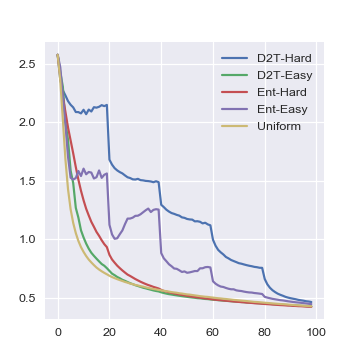

<IPython.core.display.Javascript object>


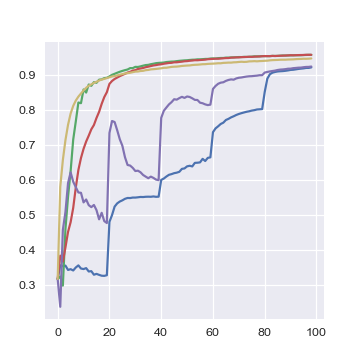

<IPython.core.display.Javascript object>


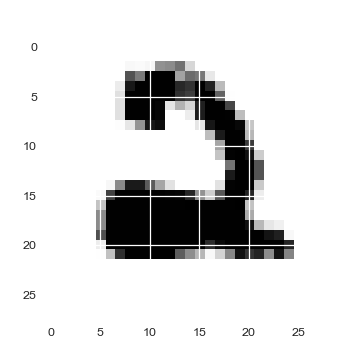

<IPython.core.display.Javascript object>


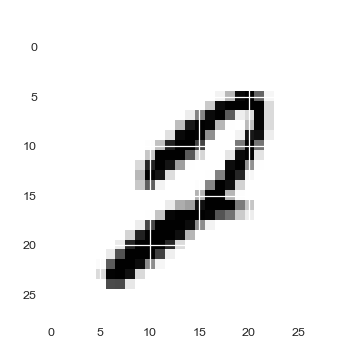

0
10.227607
1
10.141967
2
10.199358
3
10.039233
4
10.128554
5
10.201104
6
10.019811
7
10.145018
8
10.093374
9
10.188275
10
10.055366
11
10.230484
12
10.153257
13
10.177219
14
10.105639
15
10.075898
16
10.027953
17
10.058798
18
10.031606
19
10.010698
20
10.228476
21
10.170656
22
10.177589
23
10.14195
24
10.16015
25
10.088557
26
10.089949
27
10.145396
28
10.131984
29
10.203006
30
10.044258
31
10.09171
32
10.20928
33
10.202633
34
10.176366
35
10.135573
36
10.060009
37
10.227445
38
10.116615
39
10.127552
40
10.028089
41
10.108838
42
10.156306
43
10.173757
44
10.197655
45
10.078686
46
10.125213
47
10.035538
48
10.137379
49
10.14963
50
10.01613
51
10.066468
52
10.210762
53
10.074558
54
10.033356
55
10.08887
56
10.025095
57
10.139578
58
10.174335
59
10.03845
60
10.048137
61
10.132701
62
10.106662
63
10.194963
64
10.136977
65
10.155182
66
10.024017
67
10.017313
68
10.0431
69
10.140602
70
10.007345
71
10.199048
72
10.040661
73
10.168415
74
10.152801
75
10.204884
76
10.092995
77
10.182865
78
10.

In [16]:
fig = plt.figure(figsize = [4,4])
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

fig2 = plt.figure(figsize = [4,4])
ax2 = fig2.add_subplot(111)
plt.ion()
fig2.show()
fig2.canvas.draw()

fig3 = plt.figure(figsize = [4,4])
ax3 = fig3.add_subplot(111)
plt.ion()
fig3.show()
fig3.canvas.draw()

fig4 = plt.figure(figsize = [4,4])
ax4 = fig4.add_subplot(111)
plt.ion()
fig4.show()
fig4.canvas.draw()

def Biased_Batch(Inputs,Targets,Batch_Size,Sampling_Probability,Weighting_Flag = 1,NumTasks = 0,CurrentTask=0):
    while True: 
        index = np.linspace(0,Inputs.shape[0],Inputs.shape[0],endpoint=False,dtype=int)
        if NumTasks > 1:
            Cutoff = np.percentile(Sampling_Probability,np.max(100-(CurrentTask*(1/np.float(NumTasks))*100),0))
#             LowerCutoff = np.percentile(Sampling_Probability,np.max(100-(CurrentTask*(1/np.float(NumTasks))*100),0))
#             UpperCutoff = np.percentile(Sampling_Probability,np.max(100-((CurrentTask-1)*(1/np.float(NumTasks))*100),0))
#             TaskInd = Sampling_Probability >= LowerCutoff
#             TaskInd[Sampling_Probability > UpperCutoff]= False
#             Sampling_Probability[:] = 0
#             Sampling_Probability[TaskInd] = 1
#             Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
            TaskInd = Sampling_Probability >= Cutoff
            DropInd = Sampling_Probability <  Cutoff
#             Sampling_Probability[TaskInd] = 1
            Sampling_Probability[DropInd] = 0
            Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)
        
        Batch = np.random.choice(index,size=Batch_Size,replace=False,p=Sampling_Probability)
        Batch_Inputs = Inputs[Batch,:]
        Batch_Targets = Targets[Batch,:]
        if Weighting_Flag == 1:
            FullWeights = Sampling_Probability**-1
            FullWeights = FullWeights/np.mean(FullWeights)
        elif Weighting_Flag == -1:
            FullWeights = Sampling_Probability/np.mean(Sampling_Probability)
        else:
            FullWeights = np.ones(Inputs.shape[0])
            
        Weights = FullWeights[Batch]
        yield (Batch_Inputs,Batch_Targets,Weights)


for EpochLoop in  range(Num_Epochs):
    if count < Num_BurnIn:
#         ISHard_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,validation_data=[ValInputs,ValTargets],verbose=0)
#         Error = ISHard_model.test_on_batch(ValInputs,ValTargets)
#         Val_Error[count,0] = Error[0]
#         Val_Acc[count,0] = Error[1]
        
#         ISEasy_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,verbose=0)
#         Error = ISEasy_model.test_on_batch(ValInputs,ValTargets)
#         Val_Error[count,1] = Error[0]
#         Val_Acc[count,1] = Error[1]

        Uni_model.fit(TrainInputs,TrainTargets,batch_size = Batch_Size,epochs=1,verbose=0)
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,4] = Error[0]
        Val_Acc[count,4] = Error[1]
        
        D2THard_model.set_weights(Uni_model.get_weights())
        D2TEasy_model.set_weights(Uni_model.get_weights())
        
        EntHard_model.set_weights(Uni_model.get_weights())
        EntEasy_model.set_weights(Uni_model.get_weights())
        
        Error = D2THard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]
        
        Error = D2TEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]
        
        Error = EntHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]
        
        Error = EntEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,3] = Error[0]
        Val_Acc[count,3] = Error[1]
        
        
    else:
        Hard_Sampling_Probability = acquisition_function_dist_to_threshold(D2THard_model,TrainInputs,Num_Targets,1,10)
        Easy_SamplingProbability = 1/acquisition_function_dist_to_threshold(D2TEasy_model,TrainInputs,Num_Targets,1,10)
        Easy_SamplingProbability/= Easy_SamplingProbability.sum().astype(float)
        
        EntHard_Sampling_Probability = acquisition_function_BALD(EntHard_model,TrainInputs,Num_Targets,1,10)
        EntEasy_SamplingProbability = 1/acquisition_function_BALD(EntEasy_model,TrainInputs,Num_Targets,1,10)
        EntEasy_SamplingProbability/= EntEasy_SamplingProbability.sum().astype(float)

        print(Hard_Sampling_Probability.max()/Hard_Sampling_Probability.min())
        
        MaxProbInd = Hard_Sampling_Probability.argmax()
        MinProbInd = Hard_Sampling_Probability.argmin()
        
        ax3.clear()
        ax3.imshow(np.transpose(np.reshape(TrainInputs[MaxProbInd,:],[28,28])))
        fig3.canvas.draw()
                   
        ax4.clear()
        ax4.imshow(np.transpose(np.reshape(TrainInputs[MinProbInd,:],[28,28])))
        fig4.canvas.draw()
    
        
        D2THard_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Hard_Sampling_Probability,0,NumTasks,np.int(count/SwitchPoint)+1),
                                   steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

        D2TEasy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,Easy_SamplingProbability,0,NumTasks,np.int(count/SwitchPoint)+1),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        EntHard_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,EntHard_Sampling_Probability,0,NumTasks,np.int(count/SwitchPoint)+1),
                                   steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)

        EntEasy_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,EntEasy_SamplingProbability,0,NumTasks,np.int(count/SwitchPoint)+1),
                                 steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        
        Uni_model.fit_generator(Biased_Batch(TrainInputs,TrainTargets,Batch_Size,1/np.float(NumSamples)*np.ones(NumSamples)),
                                steps_per_epoch=np.int(NumSamples/Batch_Size),verbose=0)
        
        Error = D2THard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,0] = Error[0]
        Val_Acc[count,0] = Error[1]
        
        Error = D2TEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,1] = Error[0]
        Val_Acc[count,1] = Error[1]
        
        Error = Uni_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,4] = Error[0]
        Val_Acc[count,4] = Error[1]
        
        Error = EntHard_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,2] = Error[0]
        Val_Acc[count,2] = Error[1]
        
        Error = EntEasy_model.test_on_batch(ValInputs,ValTargets)
        Val_Error[count,3] = Error[0]
        Val_Acc[count,3] = Error[1]

    print(count)
    
    ax.clear()
    ax.plot(Val_Error[0:count,0],label='D2T-Hard')
    ax.plot(Val_Error[0:count,1],label='D2T-Easy')
    ax.plot(Val_Error[0:count,2],label='Ent-Hard')
    ax.plot(Val_Error[0:count,3],label='Ent-Easy')
    ax.plot(Val_Error[0:count,4],label='Uniform')
    ax.legend(loc='best')
    fig.canvas.draw()
    
    ax2.clear()
    ax2.plot(Val_Acc[0:count,0],label='IS-Hard')
    ax2.plot(Val_Acc[0:count,1],label='IS-Easy')
    ax2.plot(Val_Acc[0:count,2],label='Ent-Hard')
    ax2.plot(Val_Acc[0:count,3],label='Ent-Easy')
    ax2.plot(Val_Acc[0:count,4],label='Uniform')
    
    fig2.canvas.draw()
    
    count += 1

In [15]:
TestInputs = scipy.io.loadmat('MNIST_TestInputs.mat')
TestInputs = TestInputs['test_images']

TestTargets = scipy.io.loadmat('MNIST_TestTargets.mat')
TestTargets = TestTargets['test_targets']

In [16]:
TestError = np.zeros([5,2])
TestError[0,:] = D2THard_model.test_on_batch(TestInputs,TestTargets)
TestError[1,:] = D2TEasy_model.test_on_batch(TestInputs,TestTargets)
TestError[2,:] = EntHard_model.test_on_batch(TestInputs,TestTargets)
TestError[3,:] = EntEasy_model.test_on_batch(TestInputs,TestTargets)
TestError[4,:] = Uni_model.test_on_batch(TestInputs,TestTargets)

In [17]:
TestError

array([[0.44780427, 0.92199999],
       [0.41612533, 0.95880002],
       [0.42069563, 0.95670003],
       [0.43761912, 0.92629999],
       [0.42107648, 0.949     ]])

In [17]:
print('WITH TASKS:')

print([[0.42923832, 0.93269998],
       [0.41818482, 0.9587    ],
       [0.41003034, 0.95910001],
       [0.43967071, 0.92339998],
       [0.4183107 , 0.94739997]])


WITH TASKS:
[[0.42923832, 0.93269998], [0.41818482, 0.9587], [0.41003034, 0.95910001], [0.43967071, 0.92339998], [0.4183107, 0.94739997]]


In [21]:
Sampling_Probability = Hard_Sampling_Probability.copy()
NumTasks = np.float(5)
CurrentTask = 1

Cutoff = np.percentile(Sampling_Probability,CurrentTask*(1/NumTasks)*100)
TaskInd = Sampling_Probability >= Cutoff
DropInd = Sampling_Probability <  Cutoff
Sampling_Probability[TaskInd] = 1
Sampling_Probability[DropInd] = 0
# Sampling_Probability = Sampling_Probability/np.sum(Sampling_Probability,dtype=float)